# Intro

This notebook is used to 

1. Train regressors to predict THE LOGARITHM OF the wall time, and then 

2. Save the trained model along with the data it used. 

This includes a decision tree, a random forest, a gradient boosted decision tree model, some linear regression models, and a simple neural net.

Fully and carefully evaluating the models should be done in test-model.ipynb, but there are some functions here to give a quick idea of whether the models are worth saving.

## On predicting the logarithm instead of the wall time itself

We take this step to improve the quality of fit of the models. In order to use these regression models later for prediction (in apply_model.py and test_model.ipynb), we undo the logarithm by exponentiating the output of the model. This is the simplest way to undo the step of taking the logarithm, but perhaps not the best way, statistically speaking -- see the discussion [here](https://davegiles.blogspot.com/2013/08/forecasting-from-log-linear-regressions.html). This is an area for further improvement of the predictions.

# Notebook options

There are 4 options for each model:

1. 'train_model': Whether the notebook will train this type of model at all. If False, all other options can be ignored.

2. 'grid_search': Whether the notebook will execute a grid search to find the best combination of hyperparameters. If False, the notebook will just use some pre-set parameters (which were found in previous grid searches). Note that grid search is not available for the neural net.

3. 'training_mode': Either 'normal', 'test', or 'final'. Data is always split 50-25-25 into training, validation, and test sets. Models are always trained on the training set to begin with. This option indicates whether the model will train on the training data only ('normal' mode), the training data and the validation data ('test' mode), or all three datasets ('final' mode). Note that any extra training data (from validation/test sets) is only introduced at the very end, after the scaling of the X values, and after the grid search.

4. 'save_model': Whether the model will be saved after fitting to the data. 

The random forest model has a fifth option:

5. 'n_jobs': How many jobs to run in parallel for training. Only used during the grid search (otherwise this setting would persist when the model is saved). 

In [1]:
options = {'tree':   {'train_model': True,
                      'grid_search': False,
                      'training_mode': 'normal',
                      'save_model': True},
           'forest': {'train_model': False,
                      'grid_search': True,
                      'training_mode': 'test',
                      'save_model': True,
                      'n_jobs': 1},
           'gboost': {'train_model': False,
                      'grid_search': True,
                      'training_mode': 'test',
                      'save_model': True},
           'net':    {'train_model': False,
                      'training_mode': 'normal',
                      'save_model': False}
          }

tree_options = options['tree']
forest_options = options['forest']
gboost_options = options['gboost']
net_options = options['net']

# Imports

In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from hypopt import GridSearch
from preprocessing import get_df, scale
from persistence import model_saver
from evaluation import score_regressor, plot_regr_performance

/glade/u/home/jdubeau/github/rda-ML-resource/venv/lib/python3.8/site-packages/hypopt/model_selection.py:39: UserWarning: If you want to see estimated completion times
    while running methods in cleanlab.pruning, install tqdm
    via "pip install tqdm".
  warnings.warn(w)


# Preprocessing

## General

Much of the general preprocessing work (used for both memory and time models) is handled in preprocessing.py. This includes adding composite features and handling missing values.

In [3]:
df = get_df()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50360 entries, 6132011 to 6785810
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   rinfo            50360 non-null  object             
 1   request_type     50360 non-null  object             
 2   job_start_at     50360 non-null  datetime64[ns]     
 3   job_end_at       50360 non-null  datetime64[ns]     
 4   req_mem          50360 non-null  float64            
 5   used_mem         50360 non-null  float64            
 6   dsnum            50360 non-null  object             
 7   rqst_start_at    50327 non-null  datetime64[ns, UTC]
 8   rqst_end_at      50248 non-null  datetime64[ns, UTC]
 9   dates_init       50360 non-null  bool               
 10  slat             32123 non-null  float64            
 11  nlat             32123 non-null  float64            
 12  wlon             32140 non-null  float64            
 13  elon    

## Feature selection

All columns in X_features will be used to make predictions. 

y represents the data we'll be predicting.

In [4]:
X_features = ['PP', 'SP', 'BR', 'rqst_timespan', 'rqst_area_rect', 'converted',
              'params_num', 'grid_def_num', 'level_num',
              'ds084.1', 'ds631.1', 'ds083.3', 'ds094.0', 'ds083.2']
y_features = ['wall_time']

X = df[X_features]
y = df[y_features]

## Train/validation/test split

We split the data into training, validation, and testing sets according to the proportions in the next cell.

In [5]:
train_amt = 0.5
val_amt = 0.25
test_amt = 0.25

It's not strictly necessary to create the 'y_train_full', 'y_val_full', etc. arrays here rather than simply 'y_train' and 'y_val', since they are not storing any extra information other than the information we want to predict. However, this keeps the arrays in the notebook named in the same way as the arrays in the other notebooks (time-classifiers.ipynb and mem-classifiers.ipynb), and that simplifies testing and predicting with the model later.

In [6]:
X_train, X_target, y_train_full, y_target_full = \
                train_test_split(X, y, 
                test_size=1-train_amt, 
                random_state = 3)
X_val, X_test,y_val_full, y_test_full = \
                train_test_split(X_target, y_target_full,
                                 test_size = test_amt/train_amt,
                                 random_state = 3)


In [7]:
y_train = np.ravel(y_train_full)
y_val = np.ravel(y_val_full)
y_test = np.ravel(y_test_full)

In [8]:
log_y_train = np.log10(y_train)
log_y_val = np.log10(y_val)
log_y_test = np.log10(y_test)

## Scaling

The scaling function is from preprocessing.py -- it scales the training, validation, and test input data according to the statistics of the training set only. (This is to prevent data leakage.)

In [9]:
X_train_norm, X_val_norm, X_test_norm = \
        scale(X_train, X_val, X_test)

The data sets at our disposal now are:

X_train, X_val, X_test: unscaled input data

X_train_norm, X_val_norm, X_test_norm: scaled input data

y_train, y_val, y_test: the output data we want to predict

y_train_full, y_val_full, y_test_full: unused (see above)

log_y_train, log_y_val, log_y_test: log base 10 of the data we want to predict

## Trees and ensembles of trees

### Tree

In [10]:
if tree_options['train_model'] and tree_options['grid_search']:
    start = time.time()
    tree_param_grid = {'random_state':[3], 
                       'max_depth':range(2,15),
                       'min_samples_split':range(2,10)}
    tree_gs = GridSearch(model=DecisionTreeRegressor(), 
                              param_grid=tree_param_grid,
                              parallelize=False)
    tree_gs.fit(X_train_norm, log_y_train, 
                X_val_norm, log_y_val)
    
    print(tree_gs.best_params)
    tree = tree_gs.best_estimator_
    
    end = time.time()
    print(f"Time = {end-start}")

elif tree_options['train_model']:
    tree = DecisionTreeRegressor(max_depth=14,
                                 min_samples_split=2,
                                 random_state=3)
    tree.fit(X_train_norm, log_y_train)
else:
    tree = DecisionTreeClassifier()

### Forest

In [11]:
if forest_options['train_model'] and forest_options['grid_search']:
    start = time.time()
    forest_param_grid = {'random_state':[3], 
                         'max_depth':range(2,15),
                         'n_jobs':[forest_options['n_jobs']],
                         'n_estimators':range(50,250,25),
                         'min_samples_split':range(5,30,5)}
    forest_gs = GridSearch(model=RandomForestRegressor(), 
                                param_grid=forest_param_grid,
                                parallelize=False)
    forest_gs.fit(X_train_norm, log_y_train, 
                  X_val_norm, log_y_val)
    end = time.time()
    print(f"Time = {end-start}")
    print(forest_gs.best_params)
    forest = forest_gs.best_estimator_
    
elif forest_options['train_model']:
    forest_params = {'max_depth': 14, 
                     'n_estimators': 250,
                     'min_samples_split':5, 
                     'random_state': 3}
    
    forest = RandomForestRegressor(**forest_params)
    forest.fit(X_train_norm, log_y_train)
    
else:
    forest = RandomForestRegressor() 

### Gradient boosted trees

In [12]:
if gboost_options['train_model'] and gboost_options['grid_search']:
    start = time.time()
    gboost_param_grid = {'random_state':[3],
                         'max_depth':range(2,15),
                         'n_estimators':range(50,300,50)}
    gboost_gs = GridSearch(model=GradientBoostingRegressor(), 
                                param_grid=gboost_param_grid,
                                parallelize=False)
    gboost_gs.fit(X_train_norm, log_y_train, 
                  X_val_norm, log_y_val)
    
    print(gboost_gs.best_params)
    gboost = gboost_gs.best_estimator_
    
    end = time.time()
    print(f"Time = {end-start}")
elif gboost_options['train_model']:
    gboost = GradientBoostingRegressor(random_state=3,
                                        max_depth=14,
                                        n_estimators=150)
    gboost.fit(X_train_norm, log_y_train)
else:
    gboost = GradientBoostingRegressor()

## Neural nets

In [13]:
net = MLPRegressor(random_state=3,
                   hidden_layer_sizes=(200,200,200,200),
                   max_iter=500)

if net_options['train_model']:
    net.fit(X_train_norm, log_y_train)

# Extra training

This section trains the models on extra data if their training_mode option is set to either 'test' or 'final'.

In [14]:
models_dict = {'tree': tree,
               'forest': forest,
               'gboost': gboost,
               'net': net}

In [15]:
test_mode_X_train_norm = np.concatenate((X_train_norm, X_val_norm))
test_mode_y_train = np.concatenate([log_y_train,
                                  log_y_val])

final_mode_X_train_norm = np.concatenate((X_train_norm,
                              X_val_norm,
                              X_test_norm))
final_mode_y_train = np.concatenate([log_y_train,
                                  log_y_val,
                                  log_y_test])

In [16]:
for model_name in models_dict:
    if options[model_name]['train_model']:
        if options[model_name]['training_mode'] == 'test':
            models_dict[model_name].fit(test_mode_X_train_norm,
                                        test_mode_y_train)
        elif options[model_name]['training_mode'] == 'final':
            models_dict[model_name].fit(final_mode_X_train_norm,
                                        final_mode_y_train)

# Evaluation

Here we make some simple graphs and reports to give an idea whether our models are worth saving. Note that all figures and reports are done using the validation data -- if the models are set to 'test' or 'final' training modes, they will have already trained on this data!

The score printed by the next cell is the R^2 coefficient, defined as 1 - u/v, where u is the sum over all samples of (y_true - y_pred)^2, and v is the sum over all samples of (y_true - y_mean)^2. 

The best possible score is 1.0, and scores can be negative, indicating that the model is worse than just always predicting the average wall time.

In [18]:
for model_name in models_dict:
    if options[model_name]['train_model']:
        print(model_name+':')
        score_regressor(X_train_norm, log_y_train, 
                    X_val_norm, log_y_val, 
                    models_dict[model_name])

tree:
Training score: 0.7986
Evaluation score: 0.7555


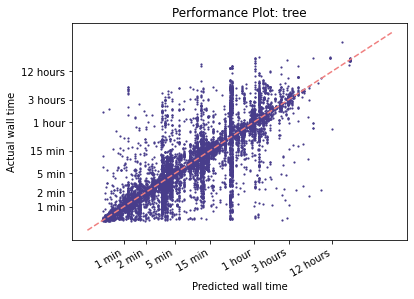

In [20]:
for model_name in models_dict:
    if options[model_name]['train_model']:
        plot_regr_performance(X_val_norm, log_y_val, 
                         models_dict[model_name],
                         model_name)

# Persistence

This section saves the models using the model_saver object from persistence.py. We begin by creating a 'notes' string for each model we intend to save, which by default just specifies which notebook options were used for that model.

In [21]:
full_model_names = {'tree': 'Decision Tree Regressor',
                    'forest': 'Random Forest Regressor',
                    'gboost': 'Gradient Boosting Regressor',
                    'net': 'Multi-layer Perceptron Regressor'}

training_data_names = {'normal': 'training',
                       'test': 'training and validation',
                       'final': 'training, validation, and testing'}

model_notes = {}

for model_name in models_dict:
    if options[model_name]['train_model'] and options[model_name]['save_model']:
        data_name = training_data_names[options[model_name]['training_mode']]
        grid_search = options[model_name]['grid_search']
        notes = f"{full_model_names[model_name]}. " \
                 + f"Trained on {data_name} data. " \
                 + f"Grid search {'not ' if not grid_search else ''}performed. " \
                 + "X values NOT scaled."
        model_notes[model_name] = notes
        
print(model_notes)

{'tree': 'Decision Tree Regressor. Trained on training data. Grid search not performed. X values NOT scaled.'}


Now we save all the desired models. Note that by passing folder_path=None as a parameter to the model_saver object, models will be saved at the default path found in persistence.py, that is, /glade/work/jdubeau/model-saves/.

This creates a folder for each model, e.g. /glade/work/jdubeau/model-saves/time_regr_forest_test2021-07-01-16:04/

In [23]:
categories_dict = None

for model_name in models_dict:
    if options[model_name]['train_model'] and options[model_name]['save_model']:
        save_name = 'time_regr_' \
                    + model_name \
                    + '_' \
                    + options[model_name]['training_mode']
        ms = model_saver(save_name, 
                         model_notes[model_name],
                         models_dict[model_name], 
                         df, 
                         categories_dict,
                         X_features,
                         X_train, y_train_full,
                         X_val, y_val_full,
                         X_test, y_test_full,
                         folder_path=None)
        ms.save()